## 参数管理
在选择了架构并设置了超参数后，我们就进⼊了训练阶段。此时，我们的⽬标是找到使损失函数最⼩化的模
型参数值。经过训练后，我们将需要使⽤这些参数来做出未来的预测。此外，有时我们希望提取参数，以便
在其他环境中复⽤它们，将模型保存下来，以便它可以在其他软件中执⾏，或者为了获得科学的理解⽽进⾏
检查。  

之前的介绍中，我们只依靠深度学习框架来完成训练的⼯作，⽽忽略了操作参数的具体细节。本节，我们将
介绍以下内容：
* 访问参数，⽤于调试、诊断和可视化；
* 参数初始化；
* 在不同模型组件间共享参数。


In [39]:
# 具有单隐藏层的多层感知机
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
print(X)
net(X)


tensor([[0.5514, 0.0943, 0.1092, 0.6634],
        [0.7828, 0.6400, 0.8056, 0.4920]])


tensor([[-0.1159],
        [-0.0412]], grad_fn=<AddmmBackward0>)

## 参数访问
从已有模型中访问参数。当通过Sequential类定义模型时，我们可以通过索引来访问模型的任意层。这
就像模型是⼀个列表⼀样，每层的参数都在其属性中。如下所⽰，我们可以检查第⼆个全连接层的参数。

In [40]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2534, -0.0451,  0.2538, -0.0536,  0.1996,  0.1573, -0.3164,  0.0380]])), ('bias', tensor([-0.2860]))])


输出的结果告诉我们⼀些重要的事情：⾸先，这个全连接层包含两个参数，分别是该层的权重和偏置。两者
都存储为单精度浮点数（float32）。注意，参数名称允许唯⼀标识每个参数，即使在包含数百个层的⽹络中也
是如此。

### 目标参数
注意，每个参数都表⽰为参数类的⼀个实例。要对参数执⾏任何操作，⾸先我们需要访问底层的数值。有⼏
种⽅法可以做到这⼀点。有些⽐较简单，⽽另⼀些则⽐较通⽤。下⾯的代码从第⼆个全连接层（即第三个神
经⽹络层）提取偏置，提取后返回的是⼀个参数类实例，并进⼀步访问该参数的值。


In [41]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)


<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.2860], requires_grad=True)
tensor([-0.2860])


参数是复合的对象，包含值、梯度和额外信息。这就是我们需要显式参数值的原因。除了值之外，我们还可
以访问每个参数的梯度。在上⾯这个⽹络中，由于我们还没有调⽤反向传播，所以参数的梯度处于初始状态。

In [42]:
net[2].weight.grad == None

True

### 一次性访问所有参数
当我们需要对所有参数执⾏操作时，逐个访问它们可能会很⿇烦。当我们处理更复杂的块（例如，嵌套块）
时，情况可能会变得特别复杂，因为我们需要递归整个树来提取每个⼦块的参数。下⾯，我们将通过演⽰来
⽐较访问第⼀个全连接层的参数和访问所有层。

In [43]:
# 访问第一个全连接层
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
# 访问所有层
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [44]:
#这为我们提供了另⼀种访问⽹络参数的⽅式
net.state_dict()['2.bias'].data


tensor([-0.2860])

### 从嵌套块收集参数
如果我们将多个块相互嵌套，参数命名约定是如何⼯作的。我们⾸先定义⼀个⽣成块的函数（可
以说是“块⼯⼚”），然后将这些块组合到更⼤的块中。


In [45]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这⾥嵌套
        net.add_module(f'block {i}', block1())
    return net


rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)



tensor([[-0.3004],
        [-0.3002]], grad_fn=<AddmmBackward0>)

In [46]:
# 设计了⽹络后，我们看看它是如何⼯作的
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引⼀样访问它们。下⾯，我们访问第⼀个主要的块
中、第⼆个⼦块的第⼀层的偏置项。

In [47]:
rgnet[0][1][0].bias.data


tensor([ 0.3187,  0.3227,  0.2924, -0.3535,  0.3685,  0.1691, -0.4183, -0.0179])

## 参数初始化
默认情况下，PyTorch会根据⼀个范围均匀地初始化权重和偏置矩阵，这个范围是根据输⼊和输出维度计算
出的。PyTorch的nn.init模块提供了多种预置初始化⽅法。

### 内置初始化
⾸先调⽤内置的初始化器。下⾯的代码将所有权重参数初始化为标准差为0.01的⾼斯随机变量，且将
偏置参数设置为0。


In [48]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01) #高斯随机变量
        nn.init.zeros_(m.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0016, -0.0024,  0.0279,  0.0026]), tensor(0.))

In [49]:
# 还可以将所有参数初始化为给定的常数，⽐如初始化为1。
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1) #常数
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

还可以对某些块应⽤不同的初始化⽅法。例如，下⾯我们使⽤Xavier初始化⽅法初始化第⼀个神经⽹络
层，然后将第三个神经⽹络层初始化为常量值42。

In [50]:
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) #Xavier方法

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42) #常数

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.1558,  0.2838, -0.1625, -0.0908])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 自定义初始化
有时，深度学习框架没有提供我们需要的初始化⽅法。在下⾯的例⼦中，我们使⽤以下的分布为任意权重参
数w定义初始化⽅法：  
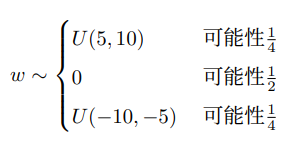  
同样，我们实现了⼀个my_init函数来应⽤到net。


In [51]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]


Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-0.0000, -0.0000, -8.6026,  8.7158],
        [ 0.0000, -5.1173,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)

In [52]:
# 注意，我们始终可以直接设置参数。
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]


tensor([42.0000,  1.0000, -7.6026,  9.7158])

### 参数绑定
有时我们希望在多个层间共享参数：我们可以定义⼀个稠密层，然后使⽤它的参数来设置另⼀个层的参数。


In [55]:
# 我们需要给共享层⼀个名称，以便可以引⽤它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))

net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同⼀个对象，⽽不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])


tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例⼦表明第三个和第五个神经⽹络层的参数是绑定的。它们不仅值相等，⽽且由相同的张量表⽰。因此，
如果我们改变其中⼀个参数，另⼀个参数也会改变。这⾥有⼀个问题：当参数绑定时，梯度会发⽣什么情况？
答案是由于模型参数包含梯度，因此在反向传播期间第⼆个隐藏层（即第三个神经⽹络层）和第三个隐藏层
（即第五个神经⽹络层）的梯度会加在⼀起。


### 小结
* 有⼏种⽅法可以访问、初始化和绑定模型参数。
* 可以使⽤⾃定义初始化⽅法。
